In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score


In [12]:
np.random.seed(44)
random.seed(44)

In [13]:
import numpy as np

class NeuralNetwork6:
    def __init__(self, layer_sizes, activation='sigmoid', output_activation='linear',
                 init_method='normal', classification=True, bias_sd=0.01,
                 reg_lambda=0.0, reg_type='L2'):
        """
        Inicjalizuje sieć neuronową MLP.
        Pozostałe parametry jak wcześniej, a dodatkowo:
        :param reg_lambda: Współczynnik regularyzacji (domyślnie 0.0 – brak regularyzacji).
        :param reg_type: Typ regularyzacji ('L2' lub 'L1', domyślnie 'L2').
        """
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.output_activation = output_activation
        self.init_method = init_method
        self.classification = classification
        self.gradient_history = []
        self.reg_lambda = reg_lambda
        self.reg_type = reg_type

        self.params = []
        for i in range(len(layer_sizes) - 1):
            n_in = layer_sizes[i]
            n_out = layer_sizes[i + 1]

            if init_method == 'normal':
                W = np.random.randn(n_out, n_in)
                b = np.random.randn(n_out, 1) * bias_sd
            elif init_method == 'uniform':
                W = np.random.rand(n_out, n_in)
                b = np.random.rand(n_out, 1) * bias_sd
            elif init_method == 'he':
                W = np.random.randn(n_out, n_in) * np.sqrt(2 / n_in)
                b = np.random.randn(n_out, 1) * bias_sd
            elif init_method == 'xavier':
                W = np.random.randn(n_out, n_in) * np.sqrt(1 / (n_in + n_out))
                b = np.random.randn(n_out, 1) * bias_sd
            else:
                W = np.random.randn(n_out, n_in)
                b = np.random.randn(n_out, 1) * bias_sd

            self.params.append({'W': W, 'b': b})

    def sigmoid(self, z):
        z = np.clip(z, -15, 15)
        return 1.0 / (1.0 + np.exp(-z))

    def relu(self, z):
        return np.maximum(0, z)

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0))
        return exps / np.sum(exps, axis=0)

    def linear(self, z):
        return z

    def tanh(self, z):
        return np.tanh(z)

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def tanh_derivative(self, a):
        return 1 - a**2

    def forward(self, X):
        activation_func = getattr(self, self.activation)
        for i in range(len(self.layer_sizes) - 2):
            X = activation_func(self.params[i]['W'] @ X + self.params[i]['b'])
        output_func = getattr(self, self.output_activation)
        return output_func(self.params[-1]['W'] @ X + self.params[-1]['b'])

    def compute_mse(self, y_true, y_pred):
        y_true = y_true.flatten()
        y_pred = y_pred.flatten()
        N = y_true.shape[0]
        return (1 / N) * np.sum((y_pred - y_true) ** 2)

    def compute_cross_entropy(self, y, y_pred):
        n = y.shape[0]
        return -np.sum(y * np.log(y_pred)) / n

    def calculate_gradient(self, x_batch, y_batch, clip_threshold=1.0):
        # Forward pass
        activations = [x_batch]
        zs = []
        num_layers = len(self.params)
        for i in range(num_layers):
            W = self.params[i]['W']
            b = self.params[i]['b']
            z = W @ activations[-1] + b
            zs.append(z)
            if i < num_layers - 1:
                a = getattr(self, self.activation)(z)
            else:
                a = getattr(self, self.output_activation)(z)
            activations.append(a)

        if y_batch.ndim == 1:
            y_batch = y_batch.reshape(activations[-1].shape)

        m = x_batch.shape[1]
        delta = (2.0 / m) * (activations[-1] - y_batch)
        if self.output_activation == 'linear':
            pass
        elif self.output_activation == 'sigmoid':
            delta *= self.sigmoid_derivative(activations[-1])
        elif self.output_activation == 'relu':
            delta *= self.relu_derivative(zs[-1])
        elif self.output_activation == 'tanh':
            delta *= self.tanh_derivative(activations[-1])
        elif self.output_activation == 'softmax':
            delta = (activations[-1] - y_batch)
        else:
            pass

        gradients = [None] * num_layers

        dW = delta @ activations[-2].T

        if self.reg_lambda:
            if self.reg_type == 'L2':
                dW += self.reg_lambda * (2*self.params[-1]['W'])
            elif self.reg_type == 'L1':
                dW += self.reg_lambda * np.sign(self.params[-1]['W'])
        db = np.sum(delta, axis=1, keepdims=True)
        gradients[-1] = {'W': dW, 'b': db}

        for i in range(num_layers - 2, -1, -1):
            delta = self.params[i+1]['W'].T @ delta
            if self.activation == 'sigmoid':
                delta *= self.sigmoid_derivative(activations[i+1])
            elif self.activation == 'relu':
                delta *= self.relu_derivative(zs[i])
            elif self.activation == 'tanh':
                delta *= self.tanh_derivative(activations[i+1])
            elif self.activation == 'linear':
                pass
            dW = delta @ activations[i].T
            if self.reg_lambda:
                if self.reg_type == 'L2':
                    dW += self.reg_lambda * (2 * self.params[i]['W'])
                elif self.reg_type == 'L1':
                    dW += self.reg_lambda * np.sign(self.params[i]['W'])
            db = np.sum(delta, axis=1, keepdims=True)
            gradients[i] = {'W': dW, 'b': db}

        # Gradient clipping
        for layer_grad in gradients:
            for key in layer_grad:
                grad_norm = np.linalg.norm(layer_grad[key])
                if grad_norm > clip_threshold:
                    layer_grad[key] *= (clip_threshold / grad_norm)

        return gradients

    def vector_to_gradients(self, grad_vector):
        """
        Odwraca funkcję gradients_to_vector.
        Na podstawie wektora grad_vector oraz oryginalnych kształtów parametrów,
        zwraca listę słowników gradientów w tej samej strukturze, co w self.params.

        :param grad_vector: Jednowymiarowy numpy array zawierający wszystkie gradienty.
        :return: Lista słowników gradientów, gdzie każdy słownik ma klucze 'W' oraz 'b'
                 z gradientami o odpowiednich kształtach.
        """
        gradients = []
        current_index = 0

        # Iterujemy przez warstwy korzystając z kształtów parametrów zapisanych w self.params
        for layer in self.params:
            layer_grad = {}

            # Kształt i liczba elementów gradientu dla wag (W)
            W_shape = layer['W'].shape
            W_size = np.prod(W_shape)
            # Wydzielamy fragment wektora dla wag i przekształcamy go do odpowiedniego kształtu
            W_grad = grad_vector[current_index: current_index + W_size].reshape(W_shape)
            current_index += W_size

            # Kształt i liczba elementów gradientu dla biasów (b)
            b_shape = layer['b'].shape
            b_size = np.prod(b_shape)
            # Wydzielamy fragment wektora dla biasów i przekształcamy go do odpowiedniego kształtu
            b_grad = grad_vector[current_index: current_index + b_size].reshape(b_shape)
            current_index += b_size

            layer_grad['W'] = W_grad
            layer_grad['b'] = b_grad

            gradients.append(layer_grad)

        return gradients


    def gradients_to_vector(self,gradients):
        """
        Zamienia listę słowników gradientów na jeden wektor.

        :param gradients: Lista słowników gradientów,
                          gdzie każdy słownik ma klucze 'W' (gradient wag)
                          oraz 'b' (gradient biasów).
        :return: Jednowymiarowy numpy array zawierający wszystkie gradienty.
        """
        grad_vector = []
        for layer_grad in gradients:
            # Spłaszczamy gradient wag i biasów i dodajemy do listy
            grad_vector.append(layer_grad['W'].ravel())
            grad_vector.append(layer_grad['b'].ravel())
        # Łączymy wszystkie spłaszczone elementy w jeden wektor
        return np.concatenate(grad_vector)


    def train(self,
              X_train,
              y_train,
              batch_size,
              epochs,
              learning_rate=0.01,
              verbose=250,
              optimizer='basic',
              beta=0.9,
              beta_1=0.9,
              beta_2=0.999,
              eps=1e-8,
              return_loss = True
              ):
        """
        Trenuje sieć neuronową metodą mini-batch gradient descent, wspierając
        różne optymalizatory (m.in. Adam, RMSProp).

        Parametry:
        ----------
        X_train : ndarray, shape [D, N]
            Dane treningowe, gdzie D to liczba cech, a N to liczba próbek.
        y_train : ndarray, shape [N] lub [1, N]
            Odpowiedzi (etykiety) dla próbek.
        batch_size : int
            Rozmiar mini-batcha.
        epochs : int
            Liczba epok treningowych.
        learning_rate : float
            Współczynnik uczenia (domyślnie 0.01).
        verbose : int
            Co ile epok wyświetlać informację o błędzie (domyślnie co 250).
        optimizer : {'basic', 'adam', 'RMSProp'}
            Wybór optymalizatora.
        beta : float
            Współczynnik momentum dla RMSProp (domyślnie 0.9).
        beta_1 : float
            Współczynnik momentum dla Adama (domyślnie 0.9).
        beta_2 : float
            Współczynnik dla średniej kwadratów gradientów w Adamie (domyślnie 0.999).
        eps : float
            Drobna stała zapobiegająca dzieleniu przez zero (domyślnie 1e-8).
        return_losses : bool
            Jeśli True, po zakończeniu treningu zwracana jest lista strat
            z każdej epoki (domyślnie False).

        Zwraca:
        -------
        Nic (lub listę strat, jeśli return_losses=True).
        """

        # Zmienna 't' dla Adama – zlicza łączną liczbę batchy (kroków optymalizacji).
        if optimizer == 'adam':
            t = 0


        # Liczba próbek
        num_samples = X_train.shape[1]

        # Pętla po epokach
        for epoch in range(epochs):
            # Losowa permutacja indeksów (shuffle)
            indices = np.random.permutation(num_samples)

            # Pętla po batchach
            for start_idx in range(0, num_samples, batch_size):
                end_idx = min(start_idx + batch_size, num_samples)
                batch_indices = indices[start_idx:end_idx]

                # Tworzymy batch
                X_batch = X_train[:, batch_indices]


                if self.classification:
                    y_batch = y_train[:,batch_indices]
                else:
                    y_batch = y_train[batch_indices]


                # Obliczamy gradienty (backprop + ewentualny clipping)
                gradients = self.calculate_gradient(X_batch, y_batch)

                # Jeśli używamy Adama lub RMSProp, przetwarzamy te gradienty
                if optimizer in ('adam', 'RMSProp'):
                    # Inkrementacja kroków optymalizacji
                    vector_gradient = self.gradients_to_vector(gradients)

                    if optimizer == 'adam':
                        t += 1
                        # Inicjalizacja m_t i v_t w pierwszym kroku
                        if epoch == 0 and start_idx == 0:
                            m_t = np.zeros_like(vector_gradient)
                            v_t = np.zeros_like(vector_gradient)
                        else:
                            # Aktualizacja pierwszego i drugiego momentu
                            m_t = beta_1 * m_t + (1 - beta_1) * vector_gradient
                            v_t = beta_2 * v_t + (1 - beta_2) * (vector_gradient ** 2)

                        # Korekta biasu (Adam)
                        m_t_hat = m_t / (1 - beta_1 ** t)
                        v_t_hat = v_t / (1 - beta_2 ** t)

                        # Obliczamy przyrost (update)
                        update = m_t_hat / (np.sqrt(v_t_hat) + eps)

                        # Zamiana wektora 'update' w strukturę gradientów
                        gradients = self.vector_to_gradients(update)

                    elif optimizer == 'RMSProp':
                        # Inicjalizacja w pierwszym kroku
                        if epoch == 0 and start_idx == 0:
                            gradient_squared_mean = np.zeros_like(vector_gradient)

                        # Aktualizacja wykładniczej średniej kwadratów gradientów
                        gradient_squared_mean = beta * gradient_squared_mean + (1 - beta) * (vector_gradient ** 2)

                        # Obliczamy przyrost
                        update = vector_gradient / (np.sqrt(gradient_squared_mean) + eps)

                        # Konwersja wektora 'update' na listę gradientów
                        gradients = self.vector_to_gradients(update)

                # Aktualizacja wag i biasów w sieci
                for i in range(len(self.params)):
                    self.params[i]['W'] -= learning_rate * gradients[i]['W']
                    self.params[i]['b'] -= learning_rate * gradients[i]['b']

            # Wyświetlamy, jeśli przypada kolej epoki zgodnie z verbose
            if epoch % verbose == verbose-1:
                y_pred = self.forward(X_train)
                if self.classification:
                    loss = self.compute_cross_entropy(y_train, y_pred)
                    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")
                else:
                    mse = self.compute_mse(y_train, y_pred)
                    print(f"Epoch {epoch + 1}/{epochs}, MSE: {mse}")


        if self.classification:
            final_loss = self.compute_cross_entropy(y_train, self.forward(X_train))
            print(f"Final loss: {final_loss}")
            if return_loss:
                return final_loss
        else:
            final_mse = self.compute_mse(y_train, self.forward(X_train))
            print(f"Final MSE: {final_mse}")
            if return_loss:
                return final_mse

    def train_with_early_stopping(self,
                                  X,
                                  y,
                                  batch_size,
                                  epochs,
                                  learning_rate=0.01,
                                  verbose=250,
                                  optimizer='basic',
                                  beta=0.9,
                                  beta_1=0.9,
                                  beta_2=0.999,
                                  eps=1e-8,
                                  patience=10,
                                  min_delta=1e-4,
                                  validation_split=0.2,
                                  return_loss=True):
        """
        Trenuje sieć neuronową metodą mini-batch gradient descent z wczesnym zatrzymywaniem.
        Dane wejściowe X i y są automatycznie dzielone na zbiór treningowy i walidacyjny zgodnie
        z parametrem validation_split (np. 0.2 oznacza 80% treningowych / 20% walidacyjnych).

        Trening przerywany jest, gdy przez 'patience' kolejnych epok strata na zbiorze walidacyjnym
        nie poprawia się o co najmniej min_delta. Po treningu rysowany jest wykres loss dla obu zbiorów.

        Parametry:
        ----------
        X : ndarray, shape [D, N]
            Dane wejściowe (D - liczba cech, N - liczba próbek).
        y : ndarray, shape [N] lub [output_size, N]
            Odpowiedzi.
        batch_size : int
            Rozmiar mini-batcha.
        epochs : int
            Maksymalna liczba epok treningowych.
        learning_rate : float
            Współczynnik uczenia.
        verbose : int
            Co ile epok wyświetlać informacje o stracie.
        optimizer : {'basic', 'adam', 'RMSProp'}
            Wybór optymalizatora.
        beta, beta_1, beta_2, eps :
            Parametry związane z optymalizatorami Adam / RMSProp.
        patience : int
            Liczba epok bez poprawy na zbiorze walidacyjnym, po których następuje przerwanie treningu.
        min_delta : float
            Minimalna zmiana straty walidacyjnej, aby uznać, że nastąpiła poprawa.
        validation_split : float
            Proporcja, w jakiej dzielimy dane (np. 0.2 oznacza, że 20% danych przeznaczamy na walidację).
        return_loss : bool
            Jeśli True, funkcja zwróci ostateczną stratę.

        Zwraca:
        -------
        Final loss na zbiorze walidacyjnym (jeśli return_loss=True), lub nic.

        Dodatkowo w self.early_stopped_epoch zapisuje się ostatnia epoka (liczona od 1),
        na której zakończono trening (czy to przez wczesne zatrzymanie, czy przez wyczerpanie epok).
        """

        # Ustalanie liczby próbek i losowe przetasowanie indeksów
        num_samples = X.shape[1]
        indices = np.random.permutation(num_samples)
        # Obliczamy liczbę próbek walidacyjnych i treningowych
        num_val = int(num_samples * validation_split)
        num_train = num_samples - num_val

        # Dzielenie zbioru na treningowy i walidacyjny
        val_indices = indices[:num_val]
        train_indices = indices[num_val:]
        X_train = X[:, train_indices]
        y_train = y[:, train_indices] if y.ndim > 1 else y[train_indices]
        X_val = X[:, val_indices]
        y_val = y[:, val_indices] if y.ndim > 1 else y[val_indices]

        train_loss_history = []
        val_loss_history = []

        best_val_loss = np.inf
        epochs_without_improvement = 0
        best_params = None

        # Dodajemy atrybut do śledzenia faktycznej epoki, na której skończyliśmy
        # (czy był to koniec puli epok, czy wczesne zatrzymanie).
        # Wstępnie ustawiamy na 0 (zostanie nadpisane przy każdej pętli).
        self.early_stopped_epoch = 0

        # Zmienna 't' dla optymalizatora Adam
        if optimizer == 'adam':
            t = 0

        num_train_samples = X_train.shape[1]

        for epoch in range(epochs):
            # Za każdym razem aktualizujemy, że "dotarliśmy" do epoki epoch + 1
            # (liczona od 1, a nie od 0).
            self.early_stopped_epoch = epoch + 1

            # Losowa permutacja próbek dla epoki
            train_perm = np.random.permutation(num_train_samples)

            # Pętla batchowa
            for start_idx in range(0, num_train_samples, batch_size):
                end_idx = min(start_idx + batch_size, num_train_samples)
                batch_idx = train_perm[start_idx:end_idx]
                X_batch = X_train[:, batch_idx]
                if self.classification:
                    y_batch = y_train[:, batch_idx]
                else:
                    y_batch = y_train[batch_idx]

                # Obliczamy gradient
                gradients = self.calculate_gradient(X_batch, y_batch)

                # Jeśli optymalizator to Adam / RMSProp
                if optimizer in ('adam', 'RMSProp'):
                    vector_gradient = self.gradients_to_vector(gradients)

                    if optimizer == 'adam':
                        t += 1
                        # Inicjalizacja w pierwszym kroku
                        if epoch == 0 and start_idx == 0:
                            m_t = np.zeros_like(vector_gradient)
                            v_t = np.zeros_like(vector_gradient)
                        else:
                            m_t = beta_1 * m_t + (1 - beta_1) * vector_gradient
                            v_t = beta_2 * v_t + (1 - beta_2) * (vector_gradient ** 2)

                        m_t_hat = m_t / (1 - beta_1 ** t)
                        v_t_hat = v_t / (1 - beta_2 ** t)
                        update = m_t_hat / (np.sqrt(v_t_hat) + eps)
                        gradients = self.vector_to_gradients(update)

                    elif optimizer == 'RMSProp':
                        if epoch == 0 and start_idx == 0:
                            gradient_squared_mean = np.zeros_like(vector_gradient)
                        gradient_squared_mean = beta * gradient_squared_mean + (1 - beta) * (vector_gradient ** 2)
                        update = vector_gradient / (np.sqrt(gradient_squared_mean) + eps)
                        gradients = self.vector_to_gradients(update)

                # Aktualizacja wag
                for i in range(len(self.params)):
                    self.params[i]['W'] -= learning_rate * gradients[i]['W']
                    self.params[i]['b'] -= learning_rate * gradients[i]['b']

            # Obliczanie straty na zbiorze treningowym i walidacyjnym po zakończeniu epoki
            y_train_pred = self.forward(X_train)
            y_val_pred = self.forward(X_val)
            if self.classification:
                train_loss = self.compute_cross_entropy(y_train, y_train_pred)
                val_loss = self.compute_cross_entropy(y_val, y_val_pred)
            else:
                train_loss = self.compute_mse(y_train, y_train_pred)
                val_loss = self.compute_mse(y_val, y_val_pred)

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)

            # Wyświetlanie postępu
            if epoch % verbose == verbose - 1:
                print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

            # Early stopping
            if best_val_loss - val_loss > min_delta:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                # Zapisujemy najlepsze parametry
                best_params = [{'W': p['W'].copy(), 'b': p['b'].copy()} for p in self.params]
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1} with Validation Loss: {val_loss}")
                if best_params is not None:
                    self.params = best_params  # Przywracamy najlepszy stan wag
                # Po wczesnym zatrzymaniu od razu wychodzimy z pętli
                break

        '''
        # Rysowanie wykresu strat
        plt.figure(figsize=(8, 5))
        epochs_range = range(1, len(train_loss_history) + 1)
        plt.plot(epochs_range, train_loss_history, label='Training Loss')
        plt.plot(epochs_range, val_loss_history, label='Validation Loss')
        plt.xlabel('Epoka')
        plt.ylabel('Loss')
        plt.title('Zmiana straty podczas treningu (Early Stopping)')
        plt.legend()
        plt.show()

        # Wypisanie końcowych wyników
        if self.classification:
            final_loss = self.compute_cross_entropy(y_val, self.forward(X_val))
            print(f"Final Validation Loss: {final_loss}")
            if return_loss:
                return final_loss
        else:
            final_mse = self.compute_mse(y_val, self.forward(X_val))
            print(f"Final Validation MSE: {final_mse}")
            if return_loss:
                return final_mse
        '''

In [14]:
def one_hot_encode(y):
    """
    This function one hot encodes the labels
    :param y: ndarray containing the labels
    :return: ndarray with the one hot encoded labels
    """
    one_hot = np.zeros((y.size, y.max() + 1))
    one_hot[np.arange(y.size), y] = 1
    return one_hot.T

In [15]:

def load_and_scale_data_regression(training_csv, test_csv, feature_col='x', target_col='y'):
    """
    Wczytuje dane z plików CSV oraz skaluje je (standaryzacja).

    Parametry:
      - training_csv: Ścieżka do pliku CSV z danymi treningowymi.
      - test_csv: Ścieżka do pliku CSV z danymi testowymi.
      - feature_col: Nazwa kolumny zawierającej cechy (domyślnie 'x').
      - target_col: Nazwa kolumny zawierającej etykiety (domyślnie 'y').

    Zwraca:
      - x_train_scaled: Zescalowane dane treningowe (features) [1 x N_train].
      - y_train_scaled: Zescalone etykiety treningowe.
      - x_test_scaled: Zescalowane dane testowe (features) [1 x N_test].
      - y_test: Oryginalne etykiety testowe (bez skalowania).
      - scaling_params: Krotka (x_mean, x_std, y_mean, y_std) – parametry skalowania,
                        które później można użyć do odwrotnej transformacji wyników.
    """
    # Wczytanie danych


    # Wyodrębnienie kolumn i przekształcenie do odpowiednich kształtów
    x_train = training_csv[[feature_col]].values.T
    y_train = training_csv[target_col].values

    x_test = test_csv[[feature_col]].values.T
    y_test = test_csv[target_col].values

    # Obliczanie średniej i odchylenia standardowego dla x oraz y
    x_mean = np.mean(x_train)
    x_std  = np.std(x_train)
    y_mean = np.mean(y_train)
    y_std  = np.std(y_train)

    # Skalowanie danych (standaryzacja)
    x_train_scaled = (x_train - x_mean) / x_std
    y_train_scaled = (y_train - y_mean) / y_std
    x_test_scaled  = (x_test - x_mean) / x_std

    scaling_params = (x_mean, x_std, y_mean, y_std)
    return x_train_scaled, y_train_scaled, x_test_scaled, y_test, scaling_params

In [16]:
def load_and_scale_data_for_classification(training_data, test_data, target_col='c'):
    """
    This function prepares the data for training and testing. It standardizes the features and one hot encodes the labels
    :param training_data: DataFrame containing training data.
    :param test_data: DataFrame containing test data.
    :param target_col: string, name of the column containing labels. Defaults to 'c'.
    :return: A tuple containing:
        - x_train_scaled (ndarray): Standardized training features [1 x N_train].
        - y_train (ndarray): One hot encoded training labels.
        - x_test_scaled (ndarray): Standardized test features [1 x N_test].
        - y_test (ndarray): Original test labels (not scaled).
    """
    x_train = training_data.drop(columns=[target_col]).values.T
    y_train = training_data[target_col].values
    x_test = test_data.drop(columns=[target_col]).values.T
    y_test = test_data[target_col].values
    x_mean = np.mean(x_train)
    x_std = np.std(x_train)
    x_train_scaled = (x_train - x_mean) / x_std
    x_test_scaled = (x_test - x_mean) / x_std
    if y_train.dtype == bool:
        y_train = y_train.astype(int)
        y_test = y_test.astype(int)
    y_train = one_hot_encode(y_train)
    return x_train_scaled, y_train, x_test_scaled, y_test

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

def run_4_scenarios_nx(
        neural_network_prototype,
        df_train,
        df_test,
        target_col,
        epochs_list,     # [epochs_basic, epochs_early, epochs_for_l1, epochs_for_l2]
        learning_rate=0.01,
        batch_size=32,
        verbose=250,
        patience=10,
        validation_split=0.2,
        reg_lambda_l1=0.01,
        reg_lambda_l2=0.01,
        n_repeats=5,
        x_col='x'        # optional for regression scenario
):
    """
    This function runs 4 distinct training scenarios on the given neural network architecture:
      (1) Basic (no early stopping, no regularization)
      (2) Early stopping (no regularization)
      (3) L1 regularization (no early stopping)
      (4) L2 regularization (no early stopping)

    Each scenario is repeated `n_repeats` times. In total, that leads to 4 × n_repeats runs.

    After each training run, it evaluates MSE or F1 (depending on regression/classification)
    on train and test sets. It also records how many epochs were effectively used
    (in early stopping, it can be fewer than the maximum). Finally, it returns (and prints)
    a summary DataFrame.

    Parameters
    ----------
    neural_network_prototype : NeuralNetwork6
        A *prototype* that indicates layer sizes, activation, classification, etc.
        We create new random initializations from scratch for each run.
    df_train : pd.DataFrame
        Unscaled training data.
    df_test : pd.DataFrame
        Unscaled test data.
    target_col : str
        Name of the target column.
    epochs_list : list of 4 ints
        [epochs_basic, epochs_early, epochs_for_l1, epochs_for_l2].
    learning_rate : float
        Learning rate passed to train/train_with_early_stopping.
    batch_size : int
        Batch size for training.
    verbose : int
        Print progress every `verbose` epochs.
    patience : int
        Early stopping patience (used only in scenario 2).
    validation_split : float
        Fraction for validation (only in scenario 2).
    reg_lambda_l1 : float
        Coefficient for L1 scenario.
    reg_lambda_l2 : float
        Coefficient for L2 scenario.
    n_repeats : int
        Number of times to repeat each scenario.
    x_col : str
        Which column to treat as 'X' if regression. Adjust as needed.

    Returns
    -------
    pd.DataFrame
        Summary with columns:
        ["Scenario", "TrainMetric", "TestMetric", "MeanEpochsUsed", "Lambda"].
    """

    # === 1) DETERMINE IF CLASSIFICATION OR REGRESSION ===
    classification_flag = neural_network_prototype.classification

    # === 2) LOAD & SCALE DATA ===
    # You likely have your own "load_and_scale_data_regression" or "load_and_scale_data_for_classification".
    if classification_flag:
        # Example (adapt as needed):
        x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled = \
            load_and_scale_data_for_classification(df_train, df_test, target_col)

        # Define a helper to compute F1
        def compute_metric_train_test(net, Xtr, Ytr, Xte, Yte):
            """
            Returns (f1_train, f1_test).
            """
            pred_tr = net.forward(Xtr)
            pred_te = net.forward(Xte)




            f1_tr = f1_score(Ytr.argmax(axis=0), pred_tr.argmax(axis=0), average='macro')
            f1_te = f1_score(Yte, pred_te.argmax(axis=0), average='macro')
            return f1_tr, f1_te
    else:
        # Regression
        x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, scaling_params = \
            load_and_scale_data_regression(df_train, df_test, x_col, target_col)

        y_train_mean = scaling_params[2]
        y_train_sd = scaling_params[3]

        def compute_metric_train_test(net, Xtr, Ytr, Xte, Yte):
            """
            Returns (mse_train, mse_test).
            We'll re-scale predictions + ground truth to original scale, then compute MSE.
            """
            pred_tr_scaled = net.forward(Xtr)
            # Re-scale
            pred_tr_unscaled = (pred_tr_scaled * y_train_sd) + y_train_mean
            Ytr_unscaled = (Ytr * y_train_sd) + y_train_mean


            pred_te_scaled = net.forward(Xte)
            pred_te_unscaled = (pred_te_scaled * y_train_sd) + y_train_mean
            Yte_unscaled = Yte

            #print(Yte_unscaled)
            # MSE
            mse_tr = net.compute_mse(Ytr_unscaled, pred_tr_unscaled)
            mse_te = net.compute_mse(Yte_unscaled, pred_te_unscaled)
            return mse_tr, mse_te

    # === 3) SCENARIOS DEFINITION ===
    # We'll store: (scenario_name, lambda_val, reg_type, use_early_stopping, epochs)
    #   scenario_name => for final table
    #   lambda_val => 0 or reg_lambda_l1 or reg_lambda_l2
    #   reg_type => 'L1' or 'L2'
    #   use_early_stopping => True/False
    #   epochs => from the epochs_list
    #
    # epochs_list is [epochs_basic, epochs_early, epochs_for_l1, epochs_for_l2]
    #   0 -> Basic
    #   1 -> Early
    #   2 -> L1
    #   3 -> L2
    scenarios = [
        ("Basic",         0.0,           "L2", False, epochs_list[0]),
        ("EarlyStopping", 0.0,           "L2", True,  epochs_list[1]),
        ("L1",            reg_lambda_l1, "L1", False, epochs_list[2]),
        ("L2",            reg_lambda_l2, "L2", False, epochs_list[3]),
    ]

    # === 4) SETUP FOR STORING RESULTS ===
    scenario_results = {
        'Scenario': [],
        'TrainMetric': [],
        'TestMetric': [],
        'MeanEpochsUsed': [],
        'Lambda': []
    }

    # Helper to create a fresh net with same architecture but random initialization:
    def instantiate_fresh_network(prototype, reg_lambda, reg_type):
        new_net = NeuralNetwork6(
            layer_sizes=prototype.layer_sizes,
            activation=prototype.activation,
            output_activation=prototype.output_activation,
            init_method=prototype.init_method,
            classification=prototype.classification,
            bias_sd=0.01,
            reg_lambda=reg_lambda,
            reg_type=reg_type
        )
        return new_net

    # === 5) LOOP OVER EACH SCENARIO, DO N REPEATS, AGGREGATE RESULTS ===
    for (scenario_name, lam_val, lam_type, use_early_stop, scenario_epochs) in scenarios:
        train_metrics_runs = []
        test_metrics_runs = []
        epochs_used_runs = []

        for _ in range(n_repeats):
            # Create fresh net
            net = instantiate_fresh_network(neural_network_prototype, lam_val, lam_type)

            # Train
            if use_early_stop:
                # We have a specialized method in the net
                net.train_with_early_stopping(
                    X=x_train_scaled,
                    y=y_train_scaled,
                    batch_size=batch_size,
                    epochs=scenario_epochs,
                    learning_rate=learning_rate,
                    verbose=verbose,
                    optimizer='basic',       # your assumption
                    patience=patience,
                    validation_split=validation_split,
                    return_loss=False        # or True if you want
                )
                # If it early-stops, net.early_stopped_epoch will be < scenario_epochs
                final_used_epochs = net.early_stopped_epoch
            else:
                # Use the basic .train()
                net.train(
                    X_train=x_train_scaled,
                    y_train=y_train_scaled,
                    batch_size=batch_size,
                    epochs=scenario_epochs,
                    learning_rate=learning_rate,
                    verbose=verbose,
                    optimizer='basic',  # no momentum or RMS, as requested
                )
                # No early stopping => used all scenario_epochs
                final_used_epochs = scenario_epochs

            # Evaluate
            train_m, test_m = compute_metric_train_test(
                net, x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled
            )
            train_metrics_runs.append(train_m)
            test_metrics_runs.append(test_m)
            epochs_used_runs.append(final_used_epochs)

        # Summarize (mean over n_repeats)
        mean_train_metric = np.mean(train_metrics_runs)
        mean_test_metric = np.mean(test_metrics_runs)
        mean_epochs_used = np.mean(epochs_used_runs)

        # Store in final results
        scenario_results['Scenario'].append(scenario_name)
        scenario_results['TrainMetric'].append(mean_train_metric)
        scenario_results['TestMetric'].append(mean_test_metric)
        scenario_results['MeanEpochsUsed'].append(mean_epochs_used)
        scenario_results['Lambda'].append(lam_val)

    # === 6) BUILD AND RETURN A RESULTS DATAFRAME ===
    df_results = pd.DataFrame(scenario_results)
    print("\n===== FINAL AGGREGATED RESULTS (over 4 scenarios) =====")
    print(df_results)
    return df_results


In [18]:
def plot_results(x_test, y_test, y_pred, prefix='test'):
    """
    Funkcja tworzy wykres punktowy porównujący
    wartości rzeczywiste (y_test) i przewidywane (y_pred)
    w zależności od x_test.

    Parametry:
    -----------
    x_test : array-like, shape (n_samples,)
        Jednowymiarowy wektor cechy (po skalowaniu).
    y_test : array-like, shape (n_samples,)
        Rzeczywiste wartości wyjściowe.
    y_pred : array-like, shape (n_samples,)
        Przewidywane wartości wyjściowe (po odskalowaniu).
    """

    plt.figure(figsize=(8, 5))

    # Wykres punktowy wartości rzeczywistych
    plt.scatter(x_test, y_test, color='blue', label='y_test')

    # Wykres punktowy wartości przewidywanych
    plt.scatter(x_test, y_pred, color='red', label='y_pred')

    plt.xlabel(f"x_{prefix}")
    plt.ylabel("Wartości y")
    plt.title("Porównanie wartości rzeczywistych i przewidywanych")
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
# Wczytywanie multimodal-sparse
multimodal_sparse_train = pd.read_csv("data/NN6/multimodal-sparse-training.csv")
multimodal_sparse_test  = pd.read_csv("data/NN6/multimodal-sparse-test.csv")

# Wczytywanie rings3-balance
rings3_balance_train = pd.read_csv("data/NN6/rings3-balance-training.csv")
rings3_balance_test  = pd.read_csv("data/NN6/rings3-balance-test.csv")

# Wczytywanie rings5-sparse
rings5_sparse_train = pd.read_csv("data/NN6/rings5-sparse-training.csv")
rings5_sparse_test  = pd.read_csv("data/NN6/rings5-sparse-test.csv")

# Wczytywanie xor3-balance
xor3_balance_train = pd.read_csv("data/NN6/xor3-balance-training.csv")
xor3_balance_test  = pd.read_csv("data/NN6/xor3-balance-test.csv")


# Multimodal_sparse

In [20]:

neural_network_0_v0 = NeuralNetwork6(layer_sizes=[1,16,16,16,1],
                                  activation='relu',
                                  output_activation='linear',
                                  init_method='he',
                                  classification=False)
run_4_scenarios_nx(
    neural_network_0_v0,
    multimodal_sparse_train,
    multimodal_sparse_test,
    target_col="y",
    epochs_list = [5000, 5000, 5000, 5000],
    learning_rate=0.1,
    batch_size=8,
    verbose=10000,
    patience=100,
    validation_split=0.2,
    reg_lambda_l1=0.001,
    reg_lambda_l2=0.001,
    n_repeats=10,
    x_col='x'
)

Final MSE: 0.00380585560527979
Final MSE: 0.0034909728555712876
Final MSE: 0.003007633132457324
Final MSE: 0.002986859549145943
Final MSE: 0.006674039270983062
Final MSE: 0.0023086052918741273
Final MSE: 0.001970298051445105
Final MSE: 0.0033746007458884775
Final MSE: 0.0022729163368881257
Final MSE: 0.0027991030772806015
Early stopping at epoch 200 with Validation Loss: 0.21644317492738338
Early stopping at epoch 245 with Validation Loss: 0.1232382173285777
Early stopping at epoch 452 with Validation Loss: 0.03425817184757449
Early stopping at epoch 344 with Validation Loss: 0.024796836347564535
Early stopping at epoch 235 with Validation Loss: 0.12095057096645999
Early stopping at epoch 266 with Validation Loss: 0.20061848153017894
Early stopping at epoch 200 with Validation Loss: 0.19044843454839683
Early stopping at epoch 634 with Validation Loss: 0.008971364971810015
Early stopping at epoch 258 with Validation Loss: 0.056286777831468016
Early stopping at epoch 202 with Validation 

,Scenario,TrainMetric,TestMetric,MeanEpochsUsed,Lambda
0,Basic,18.527153,157.634980,5000.0,0.000
1,EarlyStopping,339.325035,596.469284,303.6,0.000
2,L1,232.356754,413.553129,5000.0,0.001
3,L2,143.343319,264.799339,5000.0,0.001


In [145]:
neural_network_0_v1 = NeuralNetwork6(layer_sizes=[1,16,16,16,1],
                                     activation='relu',
                                     output_activation='linear',
                                     init_method='he',
                                     classification=False)

x_train_scaled_0, y_train_scaled_0, x_test_scaled_0, y_test_0, scaling_params_0 =  load_and_scale_data_regression(multimodal_sparse_train, multimodal_sparse_test, 'x','y')

In [146]:
neural_network_0_v1.train(x_train_scaled_0, y_train_scaled_0, batch_size = 4 ,epochs = 10000, learning_rate=0.1,verbose=10000,optimizer='basic')




Epoch 10000/10000, MSE: 0.002266792530235239
Final MSE: 0.002266792530235239


np.float64(0.002266792530235239)

In [147]:
y_predict_0_v1 = neural_network_0_v1.forward(x_train_scaled_0)
y_train_mean_0 = scaling_params_0[2]
y_train_sd_0= scaling_params_0[3]
y_predict_rescaled_0_v1 = y_predict_0_v1 * y_train_sd_0 + y_train_mean_0
y_train_rescaled_0_v1 = y_train_scaled_0 * y_train_sd_0 + y_train_mean_0
neural_network_0_v0.compute_mse(y_train_rescaled_0_v1, y_predict_rescaled_0_v1)

np.float64(12.846765587410045)

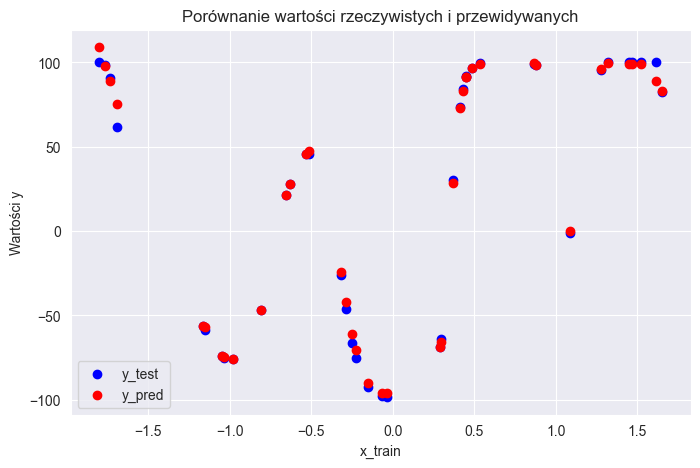

In [148]:
plot_results(x_train_scaled_0, y_train_rescaled_0_v1,  y_predict_rescaled_0_v1,prefix='train')

In [149]:
y_predict_0_v1 = neural_network_0_v1.forward(x_test_scaled_0)
y_train_mean_0 = scaling_params_0[2]
y_train_sd_0= scaling_params_0[3]
y_predict_rescaled_0_v1 = y_predict_0_v1 * y_train_sd_0 + y_train_mean_0

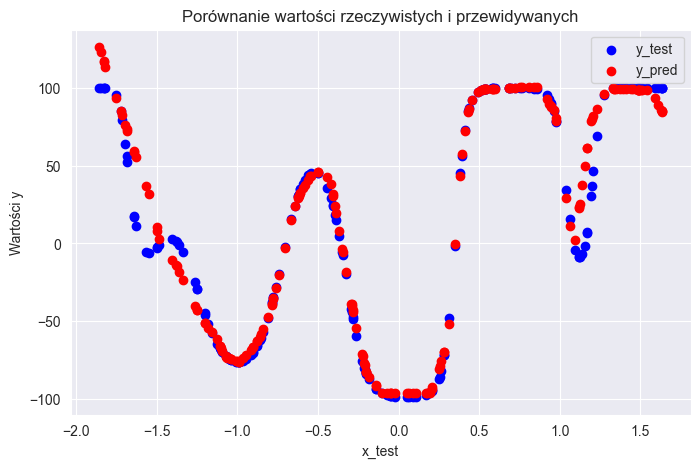

In [150]:
plot_results(x_test_scaled_0, y_test_0,  y_predict_rescaled_0_v1 , prefix='test')

# rings3

In [170]:

neural_network_1_v0 = NeuralNetwork6(layer_sizes=[2,8,8,3], activation='relu', output_activation='softmax', init_method='he', classification=True)

run_4_scenarios_nx(
    neural_network_1_v0,
    rings3_balance_train,
    rings3_balance_test,
    target_col="c",
    epochs_list = [1000, 1000, 1000, 1000],
    learning_rate=0.05,
    batch_size=100,
    verbose=1000,
    patience=25,
    validation_split=0.2,
    reg_lambda_l1=0.05,
    reg_lambda_l2=0.05,
    n_repeats=10
)

Epoch 1000/1000, Loss: 23.621489283401385
Final loss: 23.621489283401385
Epoch 1000/1000, Loss: 36.225963864182184
Final loss: 36.225963864182184
Epoch 1000/1000, Loss: 18.88925294964125
Final loss: 18.88925294964125
Epoch 1000/1000, Loss: 28.49289458862492
Final loss: 28.49289458862492
Epoch 1000/1000, Loss: 23.4714381010421
Final loss: 23.4714381010421
Epoch 1000/1000, Loss: 53.36965190722103
Final loss: 53.36965190722103
Epoch 1000/1000, Loss: 32.82862395305474
Final loss: 32.82862395305474
Epoch 1000/1000, Loss: 17.00377750278805
Final loss: 17.00377750278805
Epoch 1000/1000, Loss: 25.410619468542098
Final loss: 25.410619468542098
Epoch 1000/1000, Loss: 73.89681465052561
Final loss: 73.89681465052561
Early stopping at epoch 179 with Validation Loss: 20.56778539106354
Early stopping at epoch 128 with Validation Loss: 9.251721232778214
Early stopping at epoch 119 with Validation Loss: 16.529067011484482
Early stopping at epoch 149 with Validation Loss: 17.56146533042542
Early stoppin

,Scenario,TrainMetric,TestMetric,MeanEpochsUsed,Lambda
0,Basic,0.937323,0.885181,1000.0,0.00
1,EarlyStopping,0.887132,0.778087,133.3,0.00
2,L1,0.918309,0.828295,1000.0,0.05
3,L2,0.909068,0.817361,1000.0,0.05


In [175]:
x_train_scaled_1, y_train_1, x_test_scaled_1, y_test_1 =  load_and_scale_data_for_classification(rings3_balance_train, rings3_balance_test , target_col='c')

In [183]:
neural_network_1_v1 = NeuralNetwork6(layer_sizes=[2,8,8,3], activation='relu', output_activation='softmax', init_method='he', classification=True)

In [184]:
neural_network_1_v1.train(
    x_train_scaled_1,
    y_train_1,
    batch_size = 100,
    epochs = 1000,
    learning_rate=0.05,
    verbose=1000,
    optimizer='basic',
)



Epoch 1000/1000, Loss: 35.907078038894916
Final loss: 35.907078038894916


np.float64(35.907078038894916)

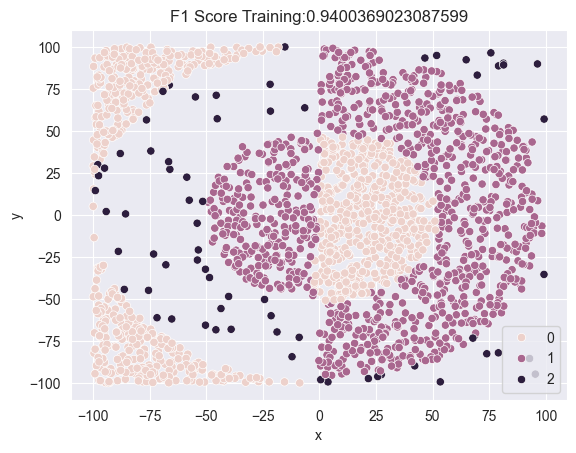

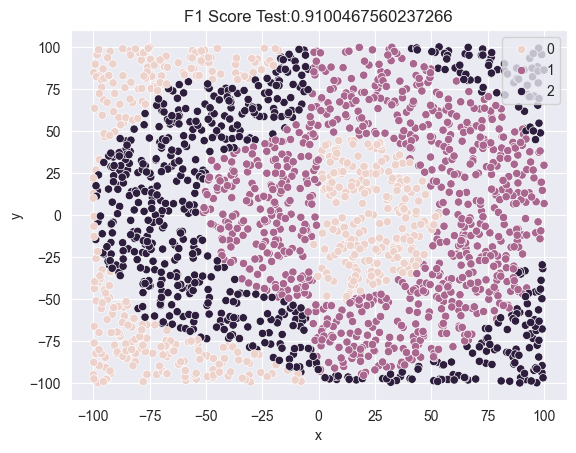

In [186]:

y_pred_train_1_v1 = neural_network_1_v1.forward(x_train_scaled_1)
sns.scatterplot(x=rings3_balance_train['x'], y=rings3_balance_train['y'], hue=y_pred_train_1_v1.argmax(axis=0))
score = f1_score(y_train_1.argmax(axis=0), y_pred_train_1_v1.argmax(axis=0), average='macro')
plt.title(f'F1 Score Training:{score}')
plt.show()

y_pred_test_1_v1 = neural_network_1_v1.forward(x_test_scaled_1)
sns.scatterplot(x=rings3_balance_test['x'], y=rings3_balance_test['y'], hue=y_pred_test_1_v1.argmax(axis=0))
score = f1_score(y_test_1, y_pred_test_1_v1.argmax(axis=0), average='macro')
plt.title(f'F1 Score Test:{score}')
plt.show()

# rings5

In [187]:

neural_network_2_v0 = NeuralNetwork6(layer_sizes=[2,16,16,5], activation='relu', output_activation='softmax', init_method='he', classification=True)

run_4_scenarios_nx(
    neural_network_2_v0,
    rings5_sparse_train,
    rings5_sparse_test,
    target_col="c",
    epochs_list = [1000, 1000, 1000, 1000],
    learning_rate=0.05,
    batch_size=100,
    verbose=1000,
    patience=25,
    validation_split=0.2,
    reg_lambda_l1=0.1,
    reg_lambda_l2=0.1,
    n_repeats=10
)

Epoch 1000/1000, Loss: 2.9502311110497605
Final loss: 2.9502311110497605
Epoch 1000/1000, Loss: 4.113040234550956
Final loss: 4.113040234550956
Epoch 1000/1000, Loss: 4.5066504147130075
Final loss: 4.5066504147130075
Epoch 1000/1000, Loss: 5.001820571013352
Final loss: 5.001820571013352
Epoch 1000/1000, Loss: 3.8897609213802014
Final loss: 3.8897609213802014
Epoch 1000/1000, Loss: 3.3950131532884824
Final loss: 3.3950131532884824
Epoch 1000/1000, Loss: 3.677408413139081
Final loss: 3.677408413139081
Epoch 1000/1000, Loss: 2.5331220569310835
Final loss: 2.5331220569310835
Epoch 1000/1000, Loss: 3.6615461776739986
Final loss: 3.6615461776739986
Epoch 1000/1000, Loss: 4.42854141883677
Final loss: 4.42854141883677
Early stopping at epoch 337 with Validation Loss: 3.196401705880097
Early stopping at epoch 408 with Validation Loss: 2.230731519158944
Early stopping at epoch 353 with Validation Loss: 2.570865314153724
Early stopping at epoch 443 with Validation Loss: 1.8989139058936242
Early s

,Scenario,TrainMetric,TestMetric,MeanEpochsUsed,Lambda
0,Basic,0.971465,0.819340,1000.0,0.0
1,EarlyStopping,0.915641,0.784590,329.0,0.0
2,L1,0.964973,0.818325,1000.0,0.1
3,L2,0.955414,0.813560,1000.0,0.1


# xor

In [190]:

neural_network_3_v0 = NeuralNetwork6(layer_sizes=[2,16,16,16,2], activation='relu', output_activation='softmax', init_method='he', classification=True)

run_4_scenarios_nx(
    neural_network_3_v0,
    xor3_balance_train,
    xor3_balance_test,
    target_col="c",
    epochs_list = [1000, 1000, 1000, 1000],
    learning_rate=0.05,
    batch_size=100,
    verbose=1000,
    patience=25,
    validation_split=0.2,
    reg_lambda_l1=0.05,
    reg_lambda_l2=0.05,
    n_repeats=10
)

Epoch 1000/1000, Loss: 0.7340352521930241
Final loss: 0.7340352521930241
Epoch 1000/1000, Loss: 10.43970525097445
Final loss: 10.43970525097445
Epoch 1000/1000, Loss: 3.09919740229305
Final loss: 3.09919740229305
Epoch 1000/1000, Loss: 14.851255351362344
Final loss: 14.851255351362344
Epoch 1000/1000, Loss: 11.016336193402244
Final loss: 11.016336193402244
Epoch 1000/1000, Loss: 7.536226616840196
Final loss: 7.536226616840196
Epoch 1000/1000, Loss: 0.30560001778611146
Final loss: 0.30560001778611146
Epoch 1000/1000, Loss: 3.7099464990506426
Final loss: 3.7099464990506426
Epoch 1000/1000, Loss: 29.481379371816896
Final loss: 29.481379371816896
Epoch 1000/1000, Loss: 8.557116434431363
Final loss: 8.557116434431363
Early stopping at epoch 63 with Validation Loss: 11.733693986616952
Early stopping at epoch 141 with Validation Loss: 4.635869257747392
Early stopping at epoch 63 with Validation Loss: 17.562333955430233
Early stopping at epoch 201 with Validation Loss: 3.691770581805174
Early 

,Scenario,TrainMetric,TestMetric,MeanEpochsUsed,Lambda
0,Basic,0.984391,0.863513,1000.0,0.00
1,EarlyStopping,0.932924,0.822223,127.6,0.00
2,L1,0.927787,0.842780,1000.0,0.05
3,L2,0.863677,0.769596,1000.0,0.05
